# Data Cleaning

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### Load Spacy's Default Things

In [2]:
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

## Read-In Data

In [3]:
health = pd.read_csv('../data/womens_health.csv', index_col = 'Unnamed: 0')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy.csv', index_col = 'Unnamed: 0')
pospar = pd.read_csv('../data/postpartum.csv', index_col = 'Unnamed: 0')

## Check Head and Shape of Data

### General Women's Health Data

In [4]:
health.head(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Been to the clinic twice and they don’t know w...,So I’ve been having problems with discharge an...,WomensHealth,1596818251,thecrazedbunny,0,1,True,2020-08-07
1,Period going on for 14 days today. Help!!,Hi guys. I'm getting a bit worried about my pe...,WomensHealth,1596822599,Help-Me-Already,4,1,True,2020-08-07


In [5]:
health.shape

(31385, 9)

### Fertility and Pregnancy Data

In [6]:
obsgyn.head(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Adding to the kitchen sink approach: I just bo...,This time I’m going to be using a menstrual cu...,TryingForABaby,1596839749,lastput1,7,1,True,2020-08-07
1,Has anyone used/or currently an app to track t...,\nMy husband and I are new to TTC.\n\nWe have ...,TryingForABaby,1596841178,ParkingFrosting4,8,1,True,2020-08-07


In [7]:
obsgyn.shape

(98138, 9)

### Postpartum Data

In [8]:
pospar.head(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Question about bottles,I'm researching baby bottles and am trying to ...,BabyBumps,1596850138,All_Hail_CC,4,1,True,2020-08-07
1,Anyone else getting that generation gap judgem...,"Aunt- I don’t eat much meat, but when I was pr...",BabyBumps,1596850152,waterfallsummer,86,1,True,2020-08-07


In [9]:
pospar.shape

(51674, 9)

## Clean Columns

### Combine `title` and `selftext` columns into a `total_text` column

The format of a Reddit post consists of a post title (`title`), and there is also an opportunity to write a body of text (`selftext`). For this project, I will be interested in analyzing all text in a post, so I will combine all of the text into a `total_text` column.

In [10]:
def create_total_text(df):
    df['total_text'] = df['title'] + ' ' + df['selftext']
    df.drop(columns = ['title', 'selftext'], inplace = True)
    return df.head(1)

In [11]:
create_total_text(health)
create_total_text(obsgyn)
create_total_text(pospar)

,subreddit,created_utc,author,num_comments,score,is_self,timestamp,total_text
0,BabyBumps,1596850138,All_Hail_CC,4,1,True,2020-08-07,Question about bottles I'm researching baby bo...


### Drop Unnecessary Columns

For this project, I am interested in using topic modeling to identify areas of concern for each domain of women's health. Therefore, the number of comments and score of each post will not be relevant and will be removed. Because the date is included under `timestamp`, the `created_utc` column will also be removed. The `is_self` column is also not needed and will be removed.

In [12]:
def clean_columns(df):
    df.drop(columns = ['created_utc', 'num_comments', 'score', 'is_self'], inplace = True)
    return df.head(1)

In [13]:
clean_columns(health)
clean_columns(obsgyn)
clean_columns(pospar)

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


## Check for Null/Missing Values

In [14]:
def display_percent_null(df):
    '''Returns the percent of values in each column that are null or missing'''
    return (df.isna().sum()/len(df)) * 100

### Women's Health Data

In [15]:
display_percent_null(health)

subreddit     0.000000
author        0.000000
timestamp     0.000000
total_text    2.450215
dtype: float64

Approximately 2.5% of the posts do not have text in the body of the post. However, because these posts have titles, this will be okay.

### Pregnancy and Fertility Data

In [16]:
display_percent_null(obsgyn)

subreddit     0.000000
author        0.000000
timestamp     0.000000
total_text    1.566162
dtype: float64

Approximately 1.5% of posts in the pregnancy and fertility data frame are null or missing. Again, because all of these posts have text in the title, this will be okay.

### Postpartum Data

In [17]:
display_percent_null(pospar)

subreddit     0.000000
author        0.000000
timestamp     0.000000
total_text    1.563649
dtype: float64

Approximately 1.6% of posts in the postpartum data frame are null or missing. Again, because all of these posts have text in the title, this will be okay.

### Drop Missing Data

In [18]:
health.dropna(inplace = True)
obsgyn.dropna(inplace = True)
pospar.dropna(inplace = True)

## Check Data Typse

In [19]:
def convert_to_datetime(df, column):
    df[column] = pd.to_datetime(df[column])
    return df.dtypes

### Women's Health Data

In [20]:
health.dtypes

subreddit     object
author        object
timestamp     object
total_text    object
dtype: object

The `subreddit`, `author`, and `total_text` columns are the appropriate data type (strings), but the `timestamp` column should be converted to a datetime object.

In [21]:
convert_to_datetime(health, 'timestamp')

subreddit             object
author                object
timestamp     datetime64[ns]
total_text            object
dtype: object

### Fertility and Pregnancy Data

In [22]:
obsgyn.dtypes

subreddit     object
author        object
timestamp     object
total_text    object
dtype: object

Similar to the Women's Health Data, the `timestamp` column should be converted to a datetime object.

In [23]:
convert_to_datetime(obsgyn, 'timestamp')

subreddit             object
author                object
timestamp     datetime64[ns]
total_text            object
dtype: object

### Postpartum Data

In [24]:
pospar.dtypes

subreddit     object
author        object
timestamp     object
total_text    object
dtype: object

Similar to the Women's Health and Fertility and Pregnancy Data, the `timestamp` column should be converted to a datetime object.

In [25]:
convert_to_datetime(pospar, 'timestamp')

subreddit             object
author                object
timestamp     datetime64[ns]
total_text            object
dtype: object

## Remove Reddit-Specific and HTML Tags

In [26]:
def remove_string(df, column, string):
    df[column] = df[column].str.replace(string, '')
    return df.head(1)

#### [removed]
If moderators of the subreddit feel that the post violates one or more of the subreddit's rules, they will remove content of the post and replace it with a "[removed]" tag. Because the [removed] tags will not add any valuable information to the post, these will be removed from posts.

In [27]:
remove_string(health, 'total_text', '\[removed\]')
remove_string(obsgyn, 'total_text', '\[removed\]')
remove_string(pospar, 'total_text', '\[removed\]')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### \n
This is a symbol that indicates a new line. Because we are only interested in the text itself, this tag will be removed.

In [28]:
remove_string(health, 'total_text', '\n')
remove_string(obsgyn, 'total_text', '\n')
remove_string(pospar, 'total_text', '\n')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### &amp ;

Sometimes, the '&' symbol is not displayed, and the HTML reference `&amp;` shows up instead. This text will be removed.

In [29]:
remove_string(health, 'total_text', '&amp;')
remove_string(obsgyn, 'total_text', '&amp;')
remove_string(pospar, 'total_text', '&amp;')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### &gt ;

Some times, the greater than symbol (>) is not properly displayed, and the HTML reference `&gt;` shows up in its place. I will remove this HTML reference.

In [30]:
remove_string(health, 'total_text', '&gt;')
remove_string(obsgyn, 'total_text', '&gt;')
remove_string(pospar, 'total_text', '&gt;')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### &lt ;

Some times, the less than symbol (<) is not properly displayed, and the HTML reference `&lt;` shows up in its place. I will remove this HTML reference.

In [31]:
remove_string(health, 'total_text', '&lt;')
remove_string(obsgyn, 'total_text', '&lt;')
remove_string(pospar, 'total_text', '&lt;')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


### Remove Website URLs

#### Reset Indices

In [32]:
health.reset_index(inplace = True)
obsgyn.reset_index(inplace = True)
pospar.reset_index(inplace = True)

In [33]:
def remove_urls(df, column):
    for i in range(0, len(df)):
        df.loc[i, column] = re.sub(r'^https?:\/\/.*[\r\n]*', '', df.loc[i, column], flags=re.MULTILINE)
        
#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/11332580        

In [34]:
remove_urls(health, 'total_text')

In [35]:
remove_urls(obsgyn, 'total_text')

In [36]:
remove_urls(pospar, 'total_text')

#### Check to see if removing URLs resulted in any null 'total_text'; If so, remove it.

In [37]:
def delete_empty_text(df, column):
    df = df[df[column] != '']
    return df.shape

In [38]:
delete_empty_text(health, 'total_text')

(30615, 5)

In [39]:
delete_empty_text(obsgyn, 'total_text')

(96595, 5)

In [40]:
delete_empty_text(pospar, 'total_text')

(50862, 5)

### Export Clean Data to CSV

In [41]:
health.to_csv('../data/womens_health_clean.csv', index = False)
obsgyn.to_csv('../data/fertility_and_pregnancy_clean.csv', index = False)
pospar.to_csv('../data/postpartum_clean.csv', index = False)

## Exploratory Data Analysis

#### Define Color Palette

In [42]:
blush = '#F7D1CD'
pink = '#E8C2CA'
light_purple = '#D1B3C4'
medium_purple = '#B392AC'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

### How many unique authors are there per subject matter?

One of the reasons why we believe that using an online health forum to identify women's health concerns could be better than a focus group or targeted survey is because of the scope of people that we will be able to reach. Here, we will explore how many women voiced their concerns for each of the topics of interest.

If it appears that several users have authored multiple posts, I will also examine these posts to eliminate the chances of including advertisements or spam in my analyses.

In [43]:
def unique_authors(df, column, title):
    return f'{title} has {df[column].nunique()} unique authors.'

#### Women's Health

In [44]:
unique_authors(health, 'author', 'Women\'s Health')

"Women's Health has 19753 unique authors."

In terms of general women's health concerns, we have posts from 19,753 unique users. Because there are 31,385 total posts, this means that 11,361 posts were contributed by a duplicate user.

#### Fertility and Pregnancy

In [45]:
unique_authors(obsgyn, 'author', 'Fertility and Pregnancy')

'Fertility and Pregnancy has 35128 unique authors.'

The Fertility and Pregnancy data (`obsgyn`) has 98,138 total posts, but only 35,517 are unique. This means that 62,621 posts are by duplicate authors. 

#### Postpartum

In [46]:
unique_authors(pospar, 'author', 'Postpartum')

'Postpartum has 21586 unique authors.'

The postpartum data has posts that were authored by 21,821 unique users. Because there are 51,674 total posts in the data frame, this means that 29,853 posts are by duplicate authors. 

### Are there any duplicated posts?

Because the number of posts is larger than the number of authors, we can deduce that some users have posted on these subreddits more than one time. To eliminate counting the same post more than one time, I will check for duplicate posts and remove them from the data.

In [47]:
def check_for_duplicates(df, column):
    duplicates = df[df[column].duplicated() == True].copy()
    return duplicates.shape[0]

#### Women's Health Data

In [48]:
check_for_duplicates(health, 'total_text')

131

In [49]:
health['total_text'].drop_duplicates(inplace = True)

There were 131 duplicate posts in the women's health data that have been removed.

#### Fertility and Pregnancy Data

In [50]:
check_for_duplicates(obsgyn, 'total_text')

2194

In [51]:
obsgyn['total_text'].drop_duplicates(inplace = True)

There were 2190 duplicate posts in the fertility and pregnancy data that have been removed.

#### Postpartum Data

In [52]:
check_for_duplicates(pospar, 'total_text')

961

In [53]:
pospar['total_text'].drop_duplicates(inplace = True)

There were 959 duplicate posts in the pospartum data that have been removed.

### Reset Indices

In [54]:
health = health.reset_index(drop = True)
obsgyn = obsgyn.reset_index(drop = True)
pospar = pospar.reset_index(drop = True)

### Word Count Distributions

#### Get Word Counts for Posts in Each Data Set

In [55]:
def get_word_count(df, column, new_column = 'word_count'):
    df[new_column] = df[column].apply(lambda x: len(x.split()))
    return df.head(1)

In [56]:
get_word_count(health, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count
0,0,WomensHealth,thecrazedbunny,2020-08-07,Been to the clinic twice and they don’t know w...,382


In [57]:
get_word_count(obsgyn, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count
0,0,TryingForABaby,lastput1,2020-08-07,Adding to the kitchen sink approach: I just bo...,81


In [58]:
get_word_count(pospar, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count
0,0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...,43


#### Visualize Word Count Distributions

In [59]:
def subplot_histogram(data, axis, title = None, x_label = None, y_label = None, color = None):
    sns.distplot(data, ax = axis, kde = False, hist_kws=dict(edgecolor="k", linewidth=.9, alpha = 0.9), color = color)
    axis.set_title(title, pad = 8, fontdict = {'fontsize':14})
    axis.set_xlabel(x_label, labelpad = 6, fontdict = {'fontsize':13})
    axis.set_ylabel(y_label, labelpad = 6, fontdict = {'fontsize':13})
    axis.tick_params(axis = 'both', labelsize = 11)
    plt.tight_layout();

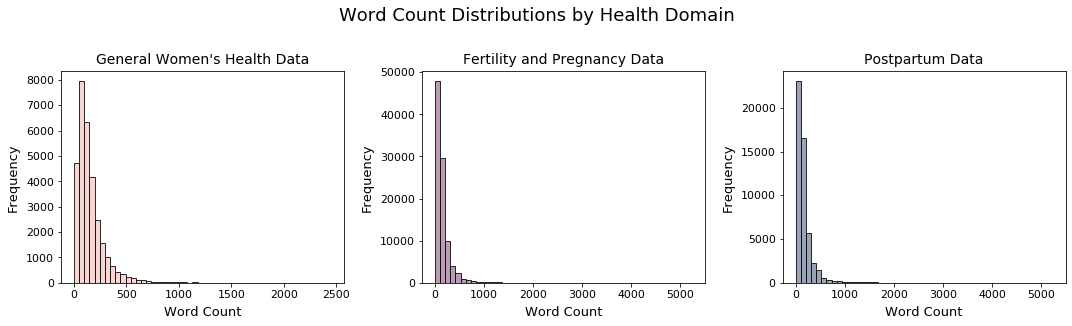

In [60]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

subplot_histogram(health['word_count'], 
                  axis = ax1,
                  title = 'General Women\'s Health Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = blush )


subplot_histogram(obsgyn['word_count'], 
                  axis = ax2,
                  title = 'Fertility and Pregnancy Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = dark_purple)

subplot_histogram(pospar['word_count'],
                  axis = ax3,
                  title = 'Postpartum Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = warm_grey)

plt.suptitle('Word Count Distributions by Health Domain', y = 1.12, size = 18);

As shown in the histograms above, the majority of posts for all three health domains are less than 1000 words in length.

**General Women's Health Domain**: The average word count for the Women's Health domain was 154.5, but word counts ranged from 1 to 2453 words. Almost 75% of posts had word counts of 193 words or less. 

**Fertility and Pregnancy Domain**: The average word count for the Fertility and Pregnancy domain was 154.2 words, but word counts varied from 1 to 5238 words. Almost 75% of posts had word counts of 182 words or less.

**Postpartum Domain**: The average word count for the Postpartum domain is 169.8 words, but word counts range from 1 to 5238. Almost 75% of posts have word counts of 195 words or less.

### Visualizing Most Common Words and Bigrams

#### Functions

In [97]:
def get_word_vector(data, ngrams = (1,1), stopwords = None, min_df = None):
    cvec = CountVectorizer(stop_words = stopwords, ngram_range = ngrams, min_df = min_df)
    words = cvec.fit_transform(data)
    df = pd.DataFrame(words.toarray(), columns = cvec.get_feature_names())
    return df

In [80]:
def get_word_sums(words_df):
    word_sum = {}
    for column in words_df.columns:
        word_sum[column] = words_df[column].sum()
    df = pd.DataFrame(sorted(word_sum.items(), key = lambda x: x[1], reverse = True), columns = ['Word', 'Count'])
    return df.sort_values('Count', ascending = False)

In [81]:
def plot_top_words(word_count_df, title = None, x_label = None, y_label = None, color = None):
    plt.figure(figsize = (18,10))
    sns.barplot(x = word_count_df['Word'][:25], y = word_count_df['Count'][:25], color = color, edgecolor = 'black')
    plt.title(title, fontdict = {'fontsize':15}, pad = 12)
    plt.xlabel('Word', fontdict = {'fontsize':13}, labelpad = 10)
    plt.ylabel('Count', fontdict = {'fontsize':13}, labelpad = 10)
    plt.tight_layout;

#### Define Corpus

In [82]:
og_health_corpus = health['total_text'].copy()
og_obsgyn_corpus = obsgyn['total_text'].copy()
og_pospar_corpus = pospar['total_text'].copy()

### Most Frequent Words - Stop Words ***NOT*** Removed

In [83]:
# Create Bag of Words

og_health_words = get_word_vector(og_health_corpus)
og_obsgyn_words = get_word_vector(og_obsgyn_corpus)
og_pospar_words = get_word_vector(og_pospar_corpus)

In [84]:
# Count the Number of Times that Each Word Appears

og_health_word_counts = get_word_sums(og_health_words)
og_obsgyn_word_counts = get_word_sums(og_obsgyn_words)
og_pospar_word_counts = get_word_sums(og_pospar_words)

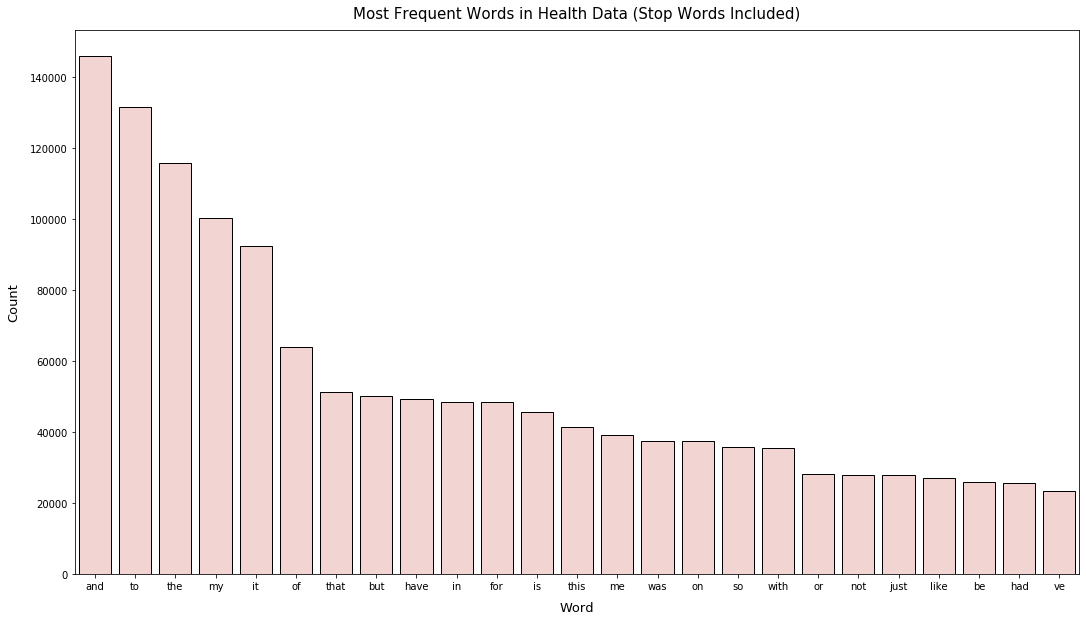

In [85]:
# Plot Top 10 Word Counts
plot_top_words(og_health_word_counts, 
               title = 'Most Frequent Words in Health Data (Stop Words Included)',
               color = blush)

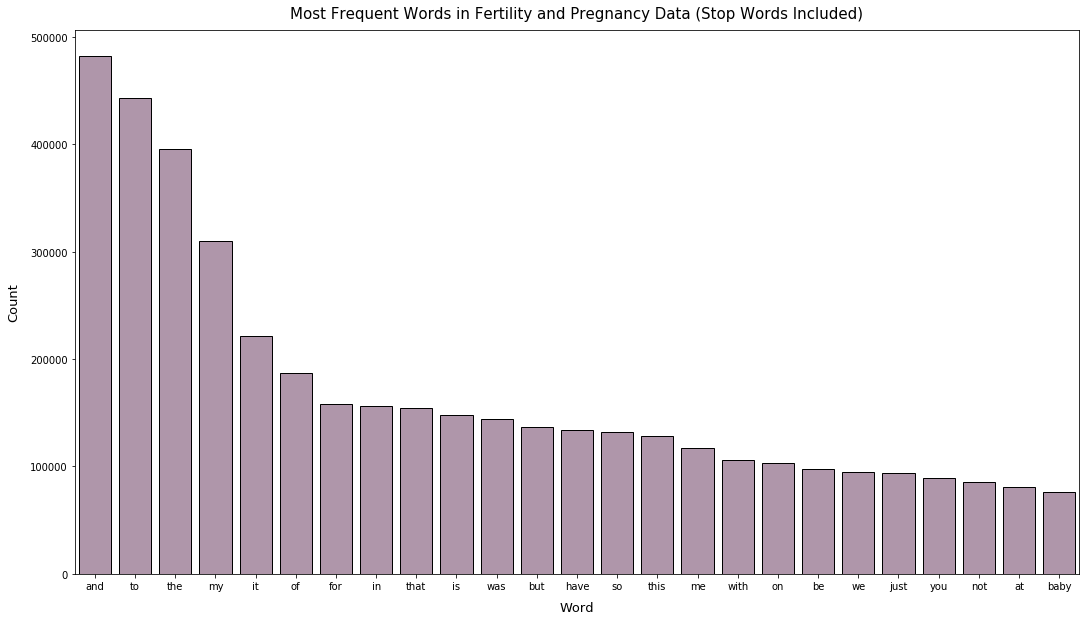

In [86]:
plot_top_words(og_obsgyn_word_counts, 
               title = 'Most Frequent Words in Fertility and Pregnancy Data (Stop Words Included)',
               color = dark_purple)

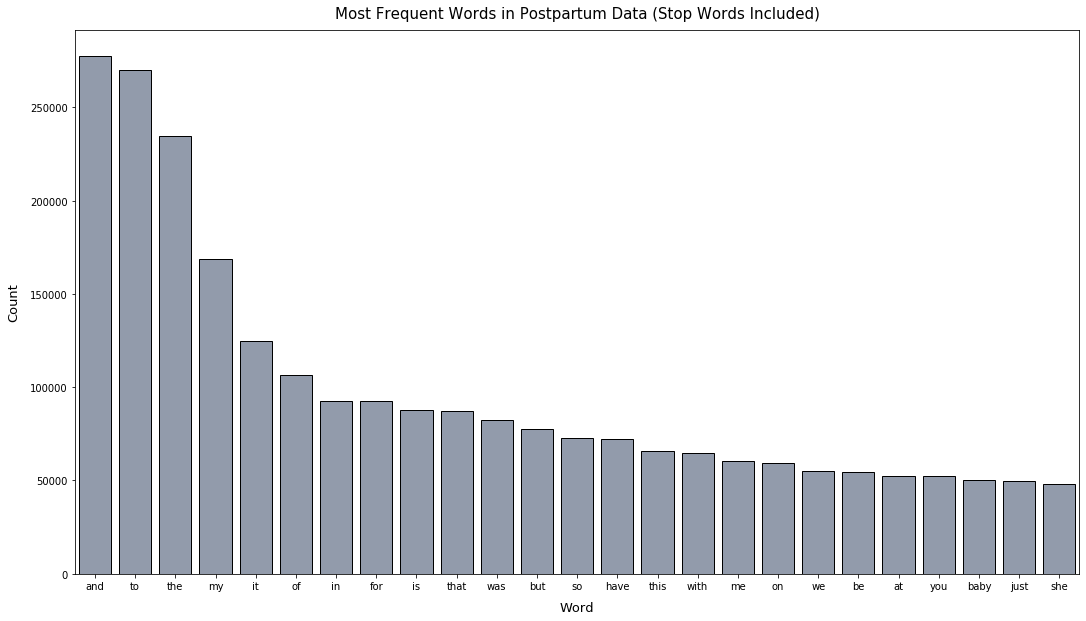

In [87]:
plot_top_words(og_pospar_word_counts, 
               title = 'Most Frequent Words in Postpartum Data (Stop Words Included)',
               color = warm_grey)

### Most Frequent Words by Data Set - Stopwords Removed

In [88]:
stop_words_nltk = set(stopwords.words('english'))
full_stop_words = stop_words_spacy.union(stop_words_nltk)

In [89]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)

In [90]:
words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think']

add_stop_words(words_to_add, full_stop_words)

In [91]:
swr_health_words = get_word_vector(og_health_corpus, stopwords = full_stop_words)
swr_obsgyn_words = get_word_vector(og_obsgyn_corpus, stopwords = full_stop_words)
swr_pospar_words = get_word_vector(og_pospar_corpus, stopwords = full_stop_words)

In [92]:
swr_health_word_counts = get_word_sums(swr_health_words)
swr_obsgyn_word_counts = get_word_sums(swr_obsgyn_words)
swr_pospar_word_counts = get_word_sums(swr_pospar_words)

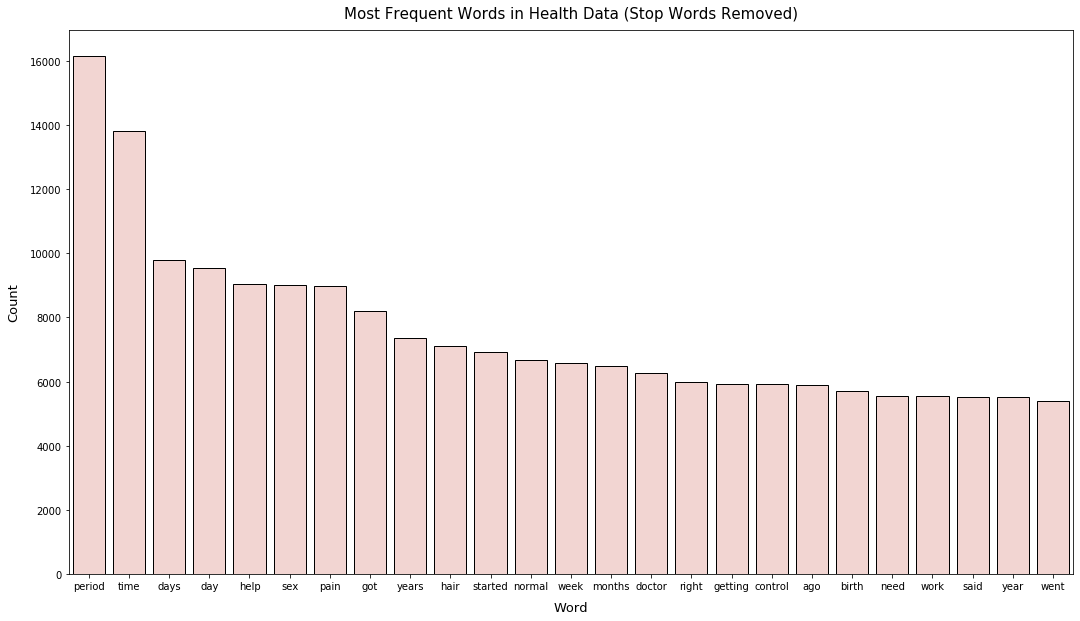

In [93]:
plot_top_words(swr_health_word_counts, 
               title = 'Most Frequent Words in Health Data (Stop Words Removed)',
               color = blush)

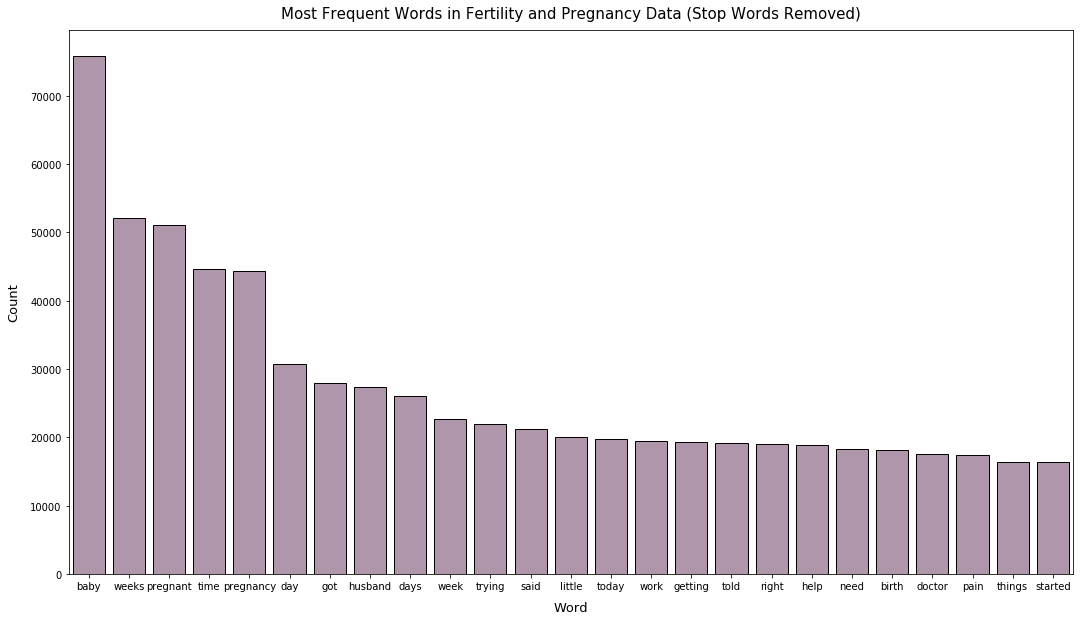

In [94]:
plot_top_words(swr_obsgyn_word_counts, 
               title = 'Most Frequent Words in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple)

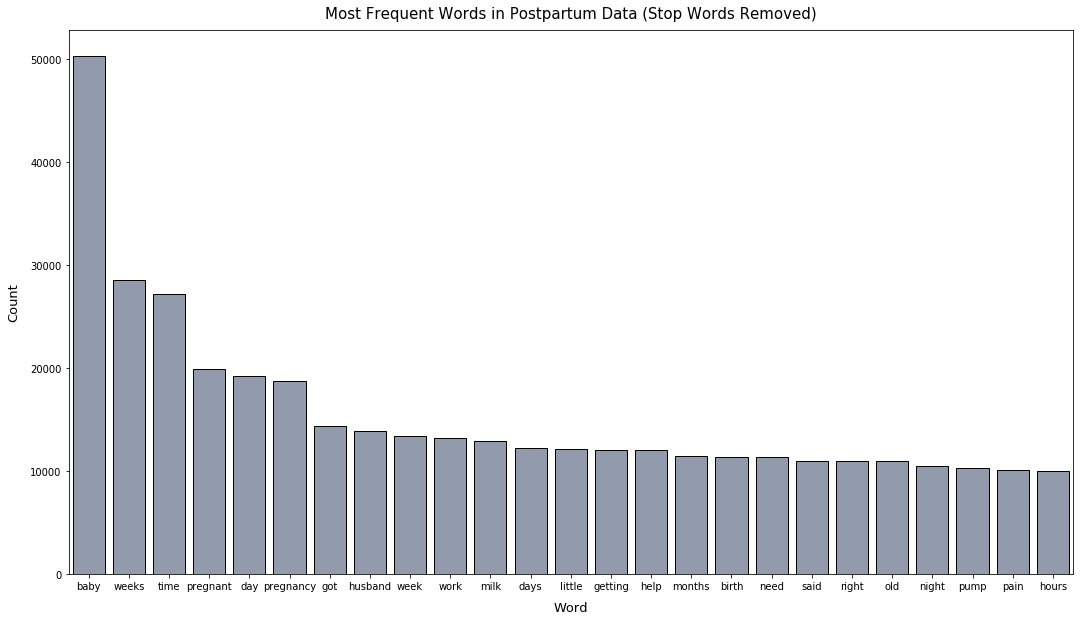

In [95]:
plot_top_words(swr_pospar_word_counts, 
               title = 'Most Frequent Words in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

### Most Frequent Bigrams by Data Set - Stopwords Removed

In [107]:
swr_health_bigrams = get_word_vector(og_health_corpus, ngrams = (2,2), stopwords = full_stop_words, min_df = 0.01)
swr_obsgyn_bigrams = get_word_vector(og_obsgyn_corpus, ngrams = (2,2), stopwords = full_stop_words, min_df = 0.01)
swr_pospar_bigrams = get_word_vector(og_pospar_corpus, ngrams = (2,2), stopwords = full_stop_words, min_df = 0.01)

In [108]:
swr_health_word_bigrams = get_word_sums(swr_health_bigrams)

In [109]:
swr_obsgyn_word_bigrams = get_word_sums(swr_obsgyn_bigrams)

In [110]:
swr_pospar_word_bigrams = get_word_sums(swr_pospar_bigrams)

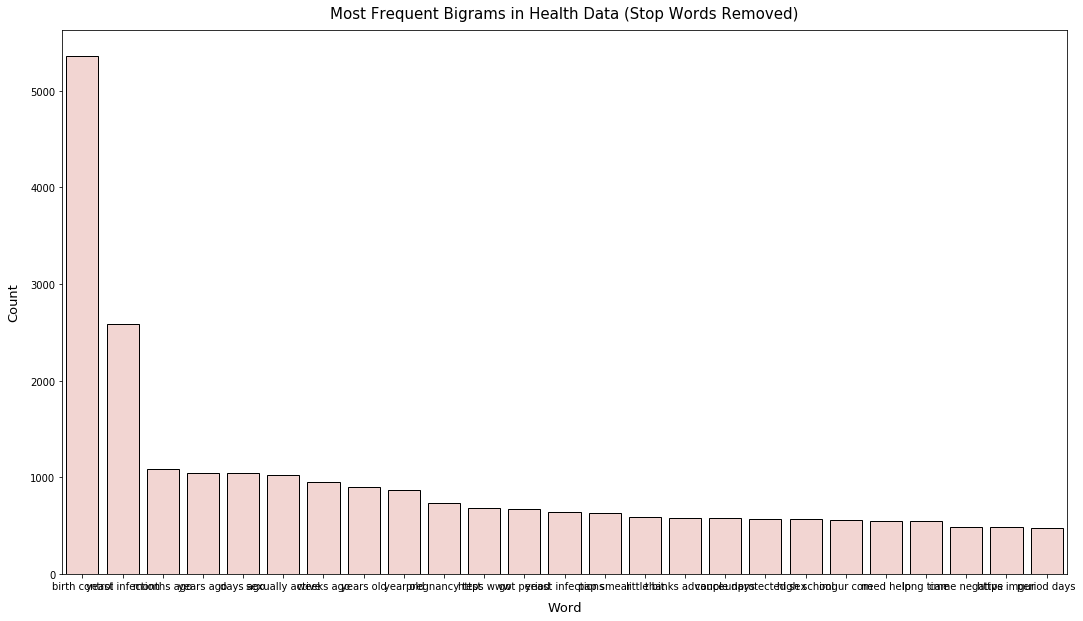

In [111]:
plot_top_words(swr_health_word_bigrams, 
               title = 'Most Frequent Bigrams in Health Data (Stop Words Removed)',
               color = blush)

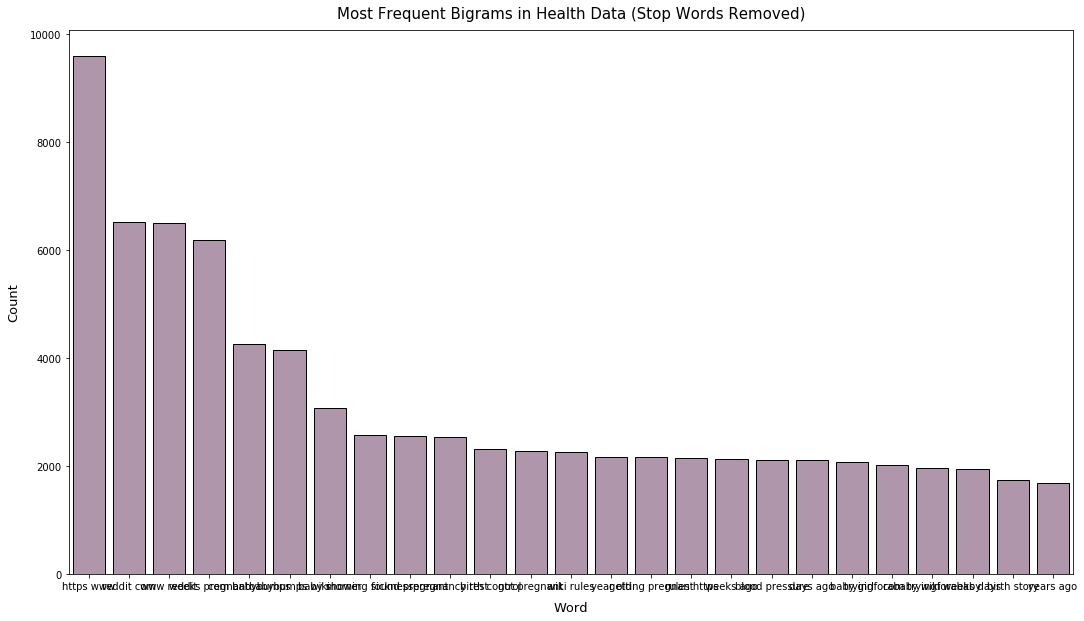

In [112]:
plot_top_words(swr_obsgyn_word_bigrams, 
               title = 'Most Frequent Bigrams in Health Data (Stop Words Removed)',
               color = dark_purple)

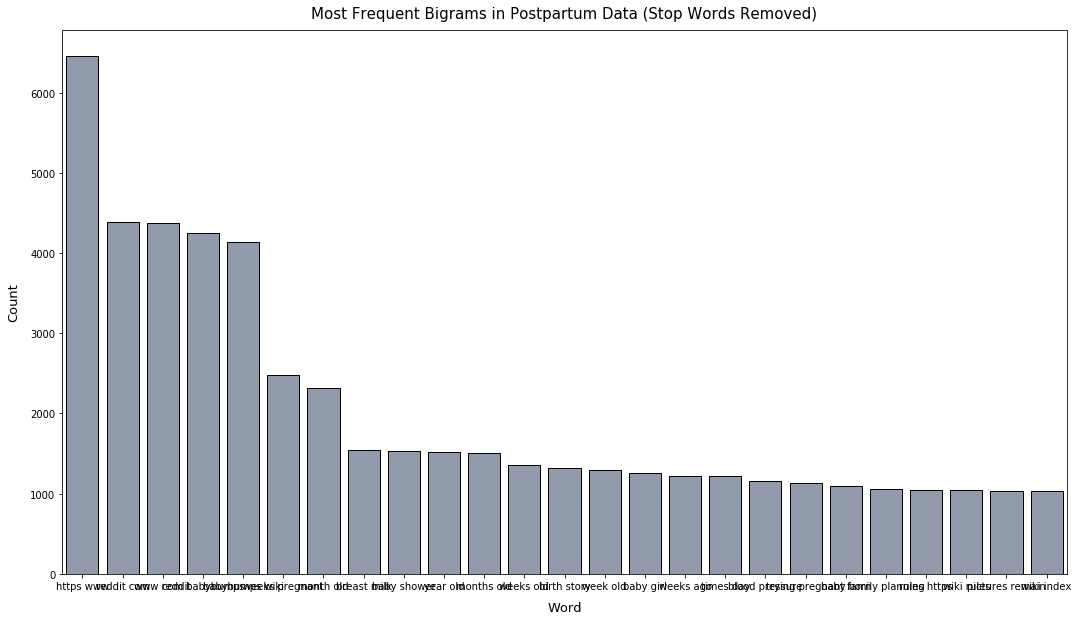

In [113]:
plot_top_words(swr_pospar_word_bigrams, 
               title = 'Most Frequent Bigrams in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

In [116]:
swr_health_bigrams

,10 days,birth control,came negative,control pills,couple days,couple months,day period,days ago,days late,days later,...,week period,weeks ago,went away,went doctor,year ago,year old,years ago,years old,yeast infection,yeast infections
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2,0
1,0,2,0,1,0,0,0,2,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
